## Baselines and benchmarks 

### Model Evaluation
This notebook evaluates different forecasting approaches, comparing error quantiles for each model:

#### Seq2Seq Model
- **Error Quantiles**: 
  - Min: 1
  - 25%: 38
  - 50%: 47
  - 85%: 75
  - 95%: 100
  - Max: 513

### Baseline Models
1. **SARIMA**
   - **Method**: Fit on the first 24 observations, then predict the next 4 steps using a sliding window, appending ground truth.
   - **MAPE Quantiles**: 
     - Min: 18.14
     - 25%: 54.63
     - 50%: 76.06
     - 85%: 137.59
     - 95%: 196.25
     - Max: --

2. **Vanilla GRU**
   - **Method**: Fitted individually on each SKU.

### Benchmark Models
1. **Temporal Convolution Network (TCN)**
2. **LagLLAMA**
   - **Description**: Lag-Llama is the first open-source foundation model for time series forecasting.
   - **Resources**: 
     - [Tweet Thread](https://twitter.com/arjunashok37/status/1755261111233114165)
     - [Model Weights](https://huggingface.co/time-series-foundation-models/Lag-Llama)
     - [Colab Demo on Zero-Shot Forecasting](https://colab.research.google.com/drive/1XxrLW9VGPlZDw3efTvUi0hQimgJOwQG6?usp=sharing)
     - [GitHub](https://github.com/time-series-foundation-models/lag-llama)
     - [Paper](https://arxiv.org/abs/2310.08278)
     

In [10]:
LOOKBACK = 6
HORIZON = 12
INPUT_COL = f"past_{LOOKBACK}_months"
OUTPUT_COL = f"past_{HORIZON}_months"
START_MONTH = "startMonth"
WEEKOFYEAR = "weekOfYear"
LISTWEEKSOFYEAR = f"list{WEEKOFYEAR}"
TARGET_WEEKS = "targetWeeks"
TARGET = 'QUANTITY_SOLD'
IDCOL = 'SKU'
DATECOL = 'DATE'
CLEANTARGET = f'clean_{TARGET}'
MONTHCOL = "month"
YEARCOL = "year"
TARGETYEAR = "listed_year"
TARGETYEAR_1 = "listed_year_1"
STATICOL="CURRENT_LEVEL"
LISTCLEANTARGET=f'list_{CLEANTARGET}'
DEPTHISTORYDAYS = 'depthHistorySku'
MINDEPTHISTORYMONTHS = 18 #(6 months input , 12 output) - Arbitrary , can be reduced later if patterns are very explicit
MINDEPTHISTORYDAYS = MINDEPTHISTORYMONTHS*31
LISTMONTHS = "listMonths"
INPUT_SEQUENCE="inputSeq"
OUTPUT_SEQUENCE="outputSeq"
NORM_STATICOL = f"normalized{STATICOL}"

import pandas as pd 
import numpy as np 

## Sarima

In [2]:
dataset = pd.read_json('../datasets/TRAIN_TEST_DATASET_SARIMA.json')
dataset=dataset[dataset[LISTCLEANTARGET].apply(len)>=52].reset_index(drop=True)
dataset.head()

,SKU,CURRENT_LEVEL,listweekOfYear,list_clean_QUANTITY_SOLD
0,-9222467576456937548,110,"[11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 2...","[1.0, 2.0, 3.0, 3.0, 1.0, 2.0, 5.0, 2.0, 2.0, ..."
1,-9209598084102175757,160,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...","[4.0, 7.0, 8.5, 10.0, 5.0, 14.0, 38.0, 33.0, 1..."
2,-9205287583597695299,7009,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[18.0, 15.0, 15.0, 12.0, 16.0, 16.0, 16.0, 16...."
3,-9204707410569096277,1061,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[4.0, 6.0, 9.0, 12.0, 40.0, 16.0, 41.0, 9.0, 5..."
4,-9178893055278907939,53,"[43, 45, 50, 51, 52, 3, 4, 5, 6, 7, 8, 9, 10, ...","[4.0, 3.0, 6.0, 2.0, 3.0, 5.0, 1.0, 3.0, 14.0,..."


In [74]:
dataset[LISTCLEANTARGET] = dataset[LISTCLEANTARGET].apply(lambda x : x[0:60])

#### SARIMA : Fit

In [80]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


In [86]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

def infer_seasonality_pacf(observations, max_lags=None, threshold=0.5):
    """
    Infer the seasonality of a time series using the PACF plot.

    Parameters:
    - observations: list or np.array of time series observations
    - max_lags: int, maximum number of lags to consider in the PACF plot
    - threshold: float, significance threshold for partial autocorrelation values

    Returns:
    - seasonality: int, inferred seasonality period
    """
    # Convert observations to numpy array
    data = np.array(observations)

    # Calculate the maximum number of lags if not provided
    if max_lags is None or max_lags >= len(data) / 2:
        max_lags = int(len(data) / 2) - 1

    # Calculate PACF values
    pacf_values = sm.tsa.pacf(data, nlags=max_lags)
    
    # Identify significant lags based on the threshold
    significant_lags = [lag for lag, value in enumerate(pacf_values) if abs(value) > threshold]
    
    # Remove the 0th lag, which is always 1 for PACF
    if 0 in significant_lags:
        significant_lags.remove(0)
    
    # Infer the seasonality as the most significant lag
    if significant_lags:
        seasonality = significant_lags[0]
    else:
        seasonality = None  # No significant seasonality found
    
    return seasonality

def fit_sarima_or_arima(data, seasonality):
    """
    Fit a SARIMA or ARIMA model on the data depending on the validity of the seasonality.
    """
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q = 1, 1, 1  # Seasonal parameters

    if seasonality is not None and seasonality > 1:
        # Fit SARIMA model
        model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, seasonality))
    else:
        # Fit ARIMA model (no seasonality)
        model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q), seasonal_order=(0, 0, 0, 0))
    
    fit = model.fit(disp=False)
    return fit

def main(observations, initial_input_size=24):
    try : 
        mape_list = []
        predictions = []

        # Ensure the observations array is at least 2 * initial_input_size in length
        if len(observations) < 2 * initial_input_size:
            raise ValueError(f"Observations array must be at least {2 * initial_input_size} in length")

        # Initial fitting on the first initial_input_size values
        train_data = observations[:initial_input_size]

        # Infer seasonality once for the initial training data
        seasonality = infer_seasonality_pacf(train_data)

        for start in range(initial_input_size, len(observations) - 4, 4):
            actual_next_values = observations[start:start + 4]

            try:
                # Fit SARIMA or ARIMA model
                model_fit = fit_sarima_or_arima(train_data, seasonality)

                # Forecast the next 4 values
                forecast = model_fit.get_forecast(steps=4)
                forecast_mean = forecast.predicted_mean  # Get the predicted mean values

                # Compute MAPE
                mape = mean_absolute_percentage_error(actual_next_values, forecast_mean) * 100
                mape_list.append(mape)
                predictions.extend(forecast_mean)
            except ValueError as e:
                print(f"Skipping due to error: {e}")
                continue

            # Append the actual next values to the training data for the next iteration
            train_data = np.concatenate([train_data, actual_next_values])

        return mape_list, predictions
    except Exception as e:
        return e



'\n# Example usage\nobservations = np.random.randn(100)  # Replace with your actual data\ninitial_input_size = 24  # Can be modified as needed\n\nmape_list, predictions = main(observations, initial_input_size)\nprint("MAPE List:", mape_list)\nprint("Predictions:", predictions)\n\n# Plotting the actual vs predicted values\nplt.figure(figsize=(10, 6))\nplt.plot(observations, label=\'Actual\', marker=\'o\')\nplt.plot(range(initial_input_size, initial_input_size + len(predictions)), predictions, label=\'Predicted\', marker=\'x\')\nplt.title(\'Actual vs Predicted Values\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'Value\')\nplt.legend()\nplt.show()'

In [99]:
sarima_output = []

for index, row in dataset.iterrows():
    observations = row[LISTCLEANTARGET]
    try:
        mape_list, predictions = main(observations)
        sarima_output.append([mape_list,predictions])
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        sarima_output.append([])  # Append an empty list in case of error

    if (index + 1) % 100 == 0:
        print(index)
        checkpoint = dataset.head(index + 1).copy()
        checkpoint['sarima_output'] = sarima_output
        checkpoint.to_json(f"../datasets/sarima_fitted_results.json")

# Final save for remaining rows
checkpoint = dataset.copy()
checkpoint['sarima_output'] = sarima_output
checkpoint.to_json("../datasets/sarima_fitted_results.json")

99


/Users/boujidax/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


199
299


/Users/boujidax/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


399
499
599
699
799
899


/Users/boujidax/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


999
1099
1199


/Users/boujidax/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/Users/boujidax/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


1299
1399
1499
1599


#### SARIMA : Evaluate

In [11]:
df_eval = pd.read_json("../datasets/sarima_fitted_results.json")

In [7]:
df_eval.sarima_output.apply(lambda x : np.mean(x[0])).quantile([0,.25,.5,.85,.95,1]).round(2).tolist()

[18.14, 54.63, 76.06, 137.59, 196.25, 3.094562792875e+17]

In [21]:
df_eval[df_eval['list_clean_QUANTITY_SOLD'].apply(min)>0].sarima_output.apply(lambda x : np.mean(x[0])).quantile([0,.25,.5,.85,.95,1]).round(2).tolist()

[19.03, 54.69, 77.04, 138.62, 196.73, 2932.46]

MAPE :  48.850642447675


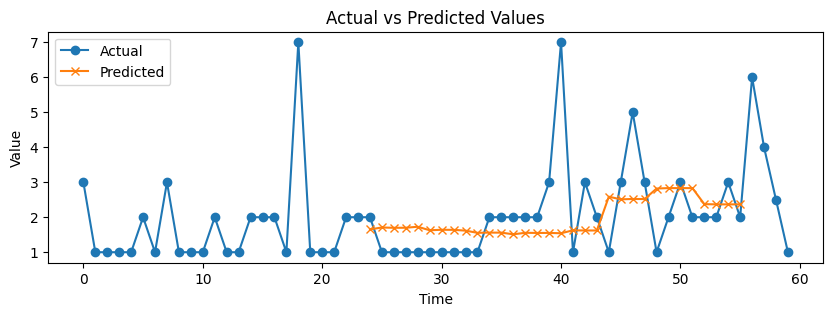

In [10]:
import matplotlib.pyplot as plt

sample = df_eval.sample()
observations = sample[LISTCLEANTARGET].values[0]# get ground truth
predictions = sample['sarima_output'].values[0][1]# get predictions 
mape = np.mean(sample['sarima_output'].values[0][0])# get predictions 
print("MAPE : ",mape)
initial_input_size = 24  # Can be modified as needed


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(observations, label='Actual', marker='o')
plt.plot(range(initial_input_size, initial_input_size + len(predictions)), predictions, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

MAPE :  122.70774452077501


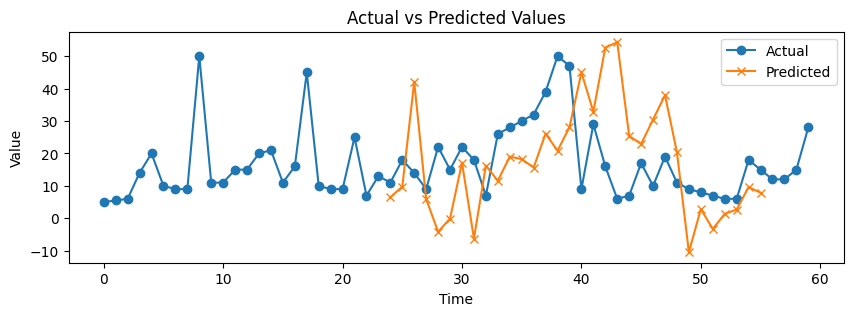

In [27]:
import matplotlib.pyplot as plt

sample = df_eval.sample()
observations = sample[LISTCLEANTARGET].values[0]# get ground truth
predictions = sample['sarima_output'].values[0][1]# get predictions 
mape = np.mean(sample['sarima_output'].values[0][0])# get predictions 
print("MAPE : ",mape)
initial_input_size = 24  # Can be modified as needed


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(observations, label='Actual', marker='o')
plt.plot(range(initial_input_size, initial_input_size + len(predictions)), predictions, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## Vanilla gru 
- Todo : DEBUG

In [ ]:

df_1 = pd.read_json('TRAIN_TEST_DATASET.json')
total_samples=df_1.shape[0]
train_set = df_1[:int(total_samples*.8)].reset_index(drop=True)
test_set = df_1[int(total_samples*.8):].reset_index(drop=True)
print(train_set.shape ,test_set.shape)

P99=np.quantile(np.concatenate([np.array(df_1.inputSeq.values.tolist())[:,:,0].reshape(-1),np.array(df_1.outputSeq.values.tolist()).reshape(-1)]),[.99])[0]
MAX_TR = P99
MIN_TR = np.concatenate([np.array(train_set.inputSeq.values.tolist())[:,:,0].reshape(-1),np.array(train_set.outputSeq.values.tolist()).reshape(-1)]).min()
print(MAX_TR , MIN_TR)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from dataset import TimeSeriesDataset


def min_max_normalize(data, min_val, max_val):
    data = torch.clamp(data, min_val, max_val)
    return (data - min_val) / (max_val - min_val)

def min_max_denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Assuming train_set and test_set are already defined as pandas DataFrames or similar structures
train_inputs_seq = torch.Tensor(train_set[INPUT_SEQUENCE].tolist()).float()
train_inputs_scalar = torch.Tensor(train_set[NORM_STATICOL].tolist()).float().reshape(-1, 1)
train_targets = torch.Tensor(train_set[OUTPUT_SEQUENCE].tolist()).float()
train_targets_weeks = torch.Tensor(train_set[TARGET_WEEKS].tolist()).float()
test_inputs_seq = torch.Tensor(test_set[INPUT_SEQUENCE].tolist()).float()
test_inputs_scalar = torch.Tensor(test_set[NORM_STATICOL].tolist()).float().reshape(-1, 1)
test_targets = torch.Tensor(test_set[OUTPUT_SEQUENCE].tolist()).float()
test_targets_weeks = torch.Tensor(test_set[TARGET_WEEKS].tolist()).float()

# Normalizing the first feature of the inputs and the outputs
train_inputs_seq[:, :, 0] = min_max_normalize(train_inputs_seq[:, :, 0], MIN_TR, MAX_TR)
test_inputs_seq[:, :, 0] = min_max_normalize(test_inputs_seq[:, :, 0], MIN_TR, MAX_TR)

train_targets = min_max_normalize(train_targets, MIN_TR, MAX_TR)
test_targets = min_max_normalize(test_targets, MIN_TR, MAX_TR)

# Create datasets
train_dataset = TimeSeriesDataset(train_inputs_seq, train_inputs_scalar, train_targets, train_targets_weeks)
test_dataset = TimeSeriesDataset(test_inputs_seq, test_inputs_scalar, test_targets, test_targets_weeks)

SAMPLE_INDICES_TO_TRACK = [ 5667, 12814, 21974,  7926, 31114, 29868, 20937,  4211, 20616,
        3318]
SAMPLE_INDICES_TO_TRACK


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming TimeSeriesDataset is defined elsewhere
# Ensure all relevant libraries and the dataset are properly imported
device = torch.device("cpu")
class VanillaGRU(nn.Module):
    def __init__(self, seq_input_dim, scalar_input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(VanillaGRU, self).__init__()
        self.gru = nn.GRU(seq_input_dim + scalar_input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, seq_inputs, scalar_inputs, trg=None, target_weeks=None, trainBool=True):
        batch_size, seq_len, _ = seq_inputs.shape
        combined_inputs = torch.cat((seq_inputs, scalar_inputs.unsqueeze(1).repeat(1, seq_len, 1)), dim=2)
        
        outputs, hidden = self.gru(combined_inputs)
        
        outputs = self.fc(self.dropout(outputs))
        
        if trg is not None:
            steps_per_chunk = 4
            for t in range(0, trg.shape[1], steps_per_chunk):
                if t + steps_per_chunk < trg.shape[1]:
                    actual_idx_end = t + steps_per_chunk
                    actual_quantity = trg[:, t:actual_idx_end].unsqueeze(2)
                    actual_weeks = target_weeks[:, t:actual_idx_end, :]
                    actual_sequence = torch.cat((actual_quantity, actual_weeks), dim=2)
                    seq_inputs = torch.cat((seq_inputs, actual_sequence), dim=1)
                    combined_inputs = torch.cat((seq_inputs, scalar_inputs.unsqueeze(1).repeat(1, seq_inputs.shape[1], 1)), dim=2)
                    outputs, hidden = self.gru(combined_inputs, hidden)
                    outputs = self.fc(self.dropout(outputs))
        
        return outputs[:, -trg.shape[1]:, :].squeeze(2)

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for batch in tqdm(iterator, desc="Training Batches"):
        seq_inputs, scalar_inputs, trg, trg_weeks = batch
        seq_inputs, scalar_inputs, trg, trg_weeks = seq_inputs.to(device), scalar_inputs.to(device), trg.to(device), trg_weeks.to(device)
        
        optimizer.zero_grad()
        output = model(seq_inputs, scalar_inputs, trg, trg_weeks, trainBool=True)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    mape_list = []

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Validation Batches"):
            seq_inputs, scalar_inputs, trg, trg_weeks = batch
            seq_inputs, scalar_inputs, trg, trg_weeks = seq_inputs.to(device), scalar_inputs.to(device), trg.to(device), trg_weeks.to(device)
            
            output = model(seq_inputs, scalar_inputs, trg, trg_weeks, trainBool=False)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
            actual = min_max_denormalize(trg.cpu().numpy(), MIN_TR, MAX_TR)
            output = min_max_denormalize(output.cpu().numpy(), MIN_TR, MAX_TR)
            
            mapes_batch = compute_mape(actual, output)
            mape_list += mapes_batch
    
    mape_quantiles = np.quantile(mape_list, [0, .25, .5, .85, .95, 1]).round(2)
    print(f'\t quantiles [0,.25,.5,.85,.95,1]  MAPE : {mape_quantiles}%')
    
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def compute_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual + 1)), axis=1).tolist()

def predict_plot(model, index_samples):
    fig, axes = plt.subplots(1, len(index_samples), figsize=(30, 3))
    axes = axes.flatten()

    for idx, ax in zip(index_samples, axes):
        seq_inputs = test_inputs_seq[idx, :, :].unsqueeze(0).to(device)
        scalar_inputs = test_inputs_scalar[idx, :].unsqueeze(0).to(device)
        trg = test_targets[idx, :].unsqueeze(0).to(device)
        trg_weeks = test_targets_weeks[idx, :].unsqueeze(0).to(device)
        
        full_actual = np.concatenate((seq_inputs[0, :, 0].cpu().detach().numpy(), trg[0, :].cpu().detach().numpy()))
        full_actual = min_max_denormalize(full_actual, MIN_TR, MAX_TR)
        
        pred = model(seq_inputs, scalar_inputs, trg_weeks, horizon=52-4, trg=trg, attention_enabled=False)
        pred = pred.reshape(-1)
        
        history = seq_inputs[0, :, 0].cpu().detach().numpy().reshape(-1)
        actual = trg[0, :].cpu().detach().numpy().reshape(-1)
        actual = min_max_denormalize(actual, MIN_TR, MAX_TR)
        
        ax.plot(full_actual, label='Actual')
        ax.plot(range(len(history), len(history) + len(pred)), pred, label='Predicted', color='red')
        ax.set_title(f'Sample {idx}')
        ax.grid()
    
    plt.tight_layout()
    plt.legend()
    plt.show()

def end_to_end(seq_input_dim, scalar_input_dim, hidden_dim, output_dim, num_layers, dropout, batch_size, no_epochs, clip, tfr):
    model = VanillaGRU(seq_input_dim, scalar_input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    best_valid_loss = float('inf')
    
    for epoch in range(no_epochs):
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, test_loader, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'vanilla_gru_model_dim_{hidden_dim}_tfr_{tfr}_layers_{num_layers}.pt')
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')   
        predict_plot(model, SAMPLE_INDICES_TO_TRACK)

In [11]:
hidden_dim = 128
output_dim = 1  # For example, (quantity)
num_layers = 2
dropout = 0.5
batch_size = 32
no_epochs = 20
clip = 1
tfr = 0.5
SAMPLE_INDICES_TO_TRACK = [0, 10, 20, 30]  # Example indices

end_to_end(4, 1, hidden_dim, output_dim, num_layers, dropout, batch_size, no_epochs, clip, tfr)

Training Batches:   0%|          | 0/4745 [00:01<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 4

## TC1D

## LagLLAMA